<a href="https://colab.research.google.com/github/tummalapallimurali/GenAI/blob/main/Knowledge_Graph_using_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Way of Storing information from an extracted task
- Consists of Node, Edge and thier relationship(triples)
- E.g. London is capital of England. Westministed is located in London.
(London, be capital, England), (Westministed, locate, London)
- To build KG , we have 2 associated nodes in graph with Entities and Vertices with relations.

To build a KG from text , to make machine understand Natural Language. using following techniqes:
- Sentence segmentation,
- Dependency parsing,,
- POS tagging,
- Entity recognition.


In [ ]:
# import spacy # preloaded library that contains several nlp functions.
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokens import Span
from spacy import load
import en_core_web_sm
nlp = en_core_web_sm

# import network x for KG creation
import networkx as nx

# import matplotlib for visualization
import matplotlib.pyplot as plt

# import utility libraries
import pandas as pd
import re
import bs4
import requests


we will use wiki sentences to create KG from kaggle(wiki_sentences_v2.csv)

In [ ]:
import pandas as pd

sentences = pd.read_csv('wiki_sentences_v2.csv')
sentences.head(6)

,sentence
0,"confused and frustrated, connie decides to lea..."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."
5,it's a parable of a woman's religious awakening—


In [ ]:
print(sentences.shape)

(4318, 1)


# sentence segmentation:
- lets test sample sentence
- To build a KG we need to split text document into sentences.
- Then use 1 subject and 1 object to extract information to create KG

In [ ]:
nlp = en_core_web_sm.load()
doc = nlp(sentences['sentence'][5])
for sent in doc.sents:
    print(sent)

for token in doc:
    print(token.text, token.pos_, token.dep_ )

# get all token.dep_
print(doc.ents)

it's a parable of a woman's religious awakening—
it PRON nsubj
's AUX ROOT
a DET det
parable NOUN attr
of ADP prep
a DET det
woman NOUN poss
's PART case
religious ADJ amod
awakening NOUN pobj
— PUNCT punct
()


#extract entities:

- we can extract entities using Parts of Speech(POS) extraceted from previous step.

#Following is design approach:

- Nouns, Pronouns would be our entities.
- When entities are across the document and span across multiple words, **we need to parse the dependecy tree of sentence.**
- Nodes and Edges
- Nodes will be entities that are present in sentences and edges are relationshios.
- we will use grammer of the sentence for relationship.

# IF a entity is span across multiple words, then:
- Extract subject and object (entities)- can be accessed through token.dep_

In [ ]:
def get_entities(sent):
    doc = nlp(sent)
    ent_list = []
    for ent in doc.ents:
        ent_list.append((ent.text, ent.label_))
    return ent_list

# test

get_entities(sentences['sentence'][200])



[('f. w. murnau', 'PERSON'), ('first', 'ORDINAL')]

In [ ]:
# we need more advanced function to get correct entities

def get_entities(sent):
  '''chunk 1: Defined a few empty variables in this chunk.
  prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word
  in the sentence and that previous word itself, respectively.
  prefix and modifier will hold the text that is associated with the subject or the object.'''

  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  '''Next, we will loop through the tokens in the sentence.
  We will first check if the token is a punctuation mark or not.
  If yes, then we will ignore it and move on to the next token.
If the token is a part of a compound word (dependency tag = “compound”),we will keep it in the prefix variable.
A compound word is a combination of multiple words linked to form a word with a new meaning
(example – “Football Stadium”, “animal lover”). As and when we come across a subject or an object in the sentence,
we will add this prefix to it.We will do the same thing with the modifier words,
such as “nice shirt”, “big house”, etc.'''

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      if tok.dep_ == "PRON":
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      ## chunk 5
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

#chunk 3
'''Here, if the token is the subject, then it will be captured as the first entity in the ent1
variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.'''

#chunk 4
'''Here, if the token is the object, then it will be captured as the second entity in the ent2
variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.'''

#chunk 5
'''Once we have captured the subject and the object in the sentence,
we will update the previous token and its dependency tag.'''


'Once we have captured the subject and the object in the sentence, \nwe will update the previous token and its dependency tag.'

In [ ]:
get_entities("the film had 200 patents")


['film', '200  patents']

In [ ]:
get_entities(sentences['sentence'][200])

['f. w. murnau', 'themed  movie']

In [ ]:
!pip install tqdm
from tqdm import tqdm # import the tqdm function

entity_pairs = []

for i in tqdm(sentences["sentence"]): # use tqdm function
    entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:45<00:00, 95.41it/s]


In [ ]:
entity_pairs[0:20]

[['connie', 'own'],
 ['later  scream', 'distance'],
 ['christian', 'then  elder'],
 ['temple', 'fire'],
 ['', 'outside cult him'],
 ['it', 'religious  awakening'],
 ['c. mackenzie', 'craig cast'],
 ['later craig di francia', 'action cast'],
 ['sebastian  maniscalco', 'later paul ben cast'],
 ['we', 'just  film'],
 ['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', 'men']]

As you can see, there are a few pronouns in these entity pairs such as ‘we’, ‘it’, ‘she’, etc. We’d like to have proper nouns or nouns instead. Perhaps we can further improve the get_entities( ) function to filter out pronouns


In [ ]:
# Extract relations
'''Entity extraction is half the job done. To build a knowledge graph, we need edges to connect
the nodes (entities) to one another.
These edges are the relations between a pair of nodes.
Our hypothesis is that the predicate is actually the main verb in a sentence.
For example, in the sentence – “Sixty Hollywood musicals were released in 1929”,
the verb is “released in” and this is what we are going to use as the predicate for
the triple generated from this sentence.

The function below is capable of capturing such predicates from the sentences.
Here, I have used spaCy’s rule-based matching:'''

def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object
  matcher = Matcher(nlp.vocab)

  #define the pattern
  pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]

  matcher.add("matching_1", [pattern])

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]]

  return(span.text)

In [ ]:
get_relation("the film had 200 patents")

'had'

In [ ]:
relations = [get_relation(i) for i in tqdm(sentences['sentence'])]

100%|██████████| 4318/4318 [00:55<00:00, 77.76it/s]


In [ ]:
pd.Series(relations).value_counts()[:50]

,count
is,364
was,308
released on,90
are,74
include,73
were,68
released,41
's,39
composed by,34
became,31


In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

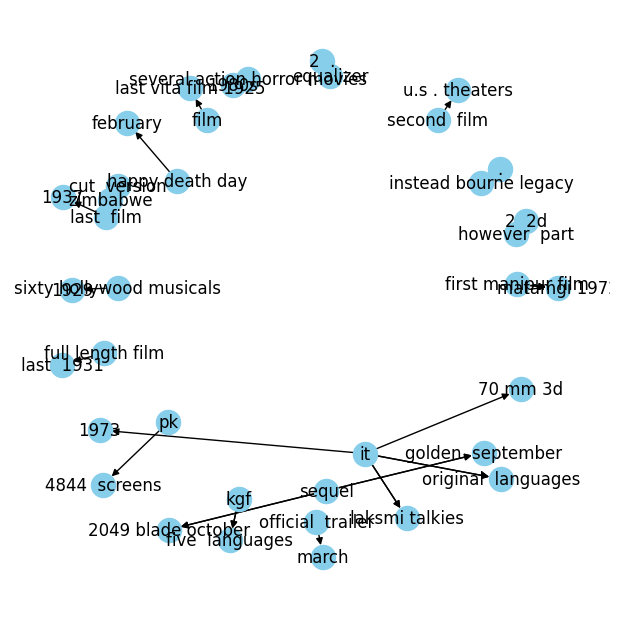

In [ ]:
plt.figure(figsize=(6,6))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

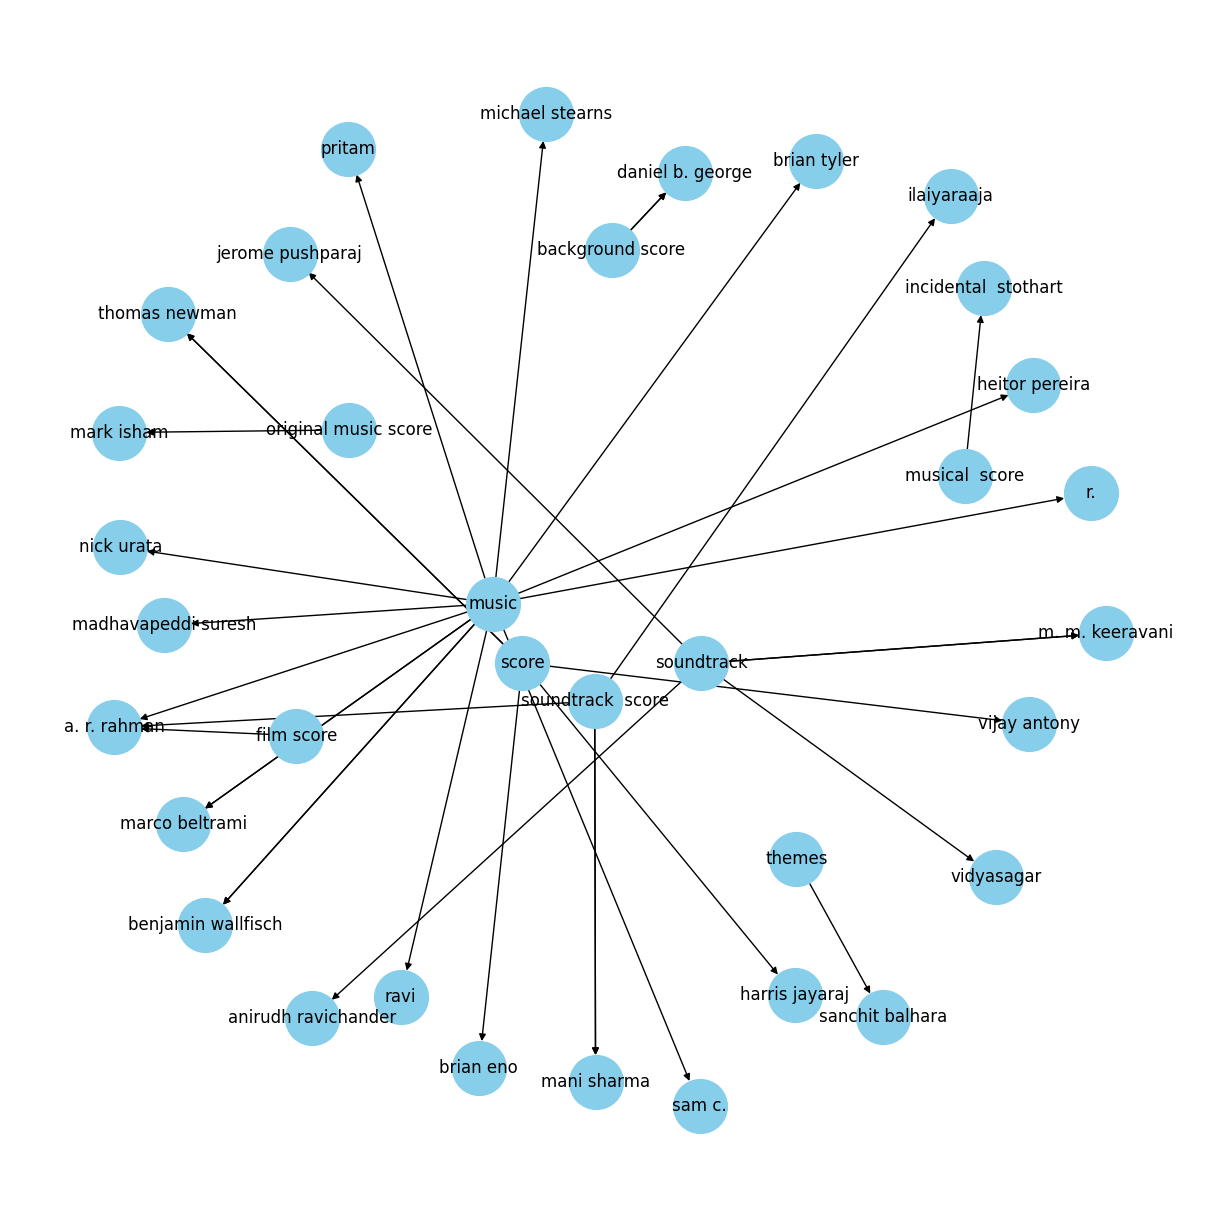

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

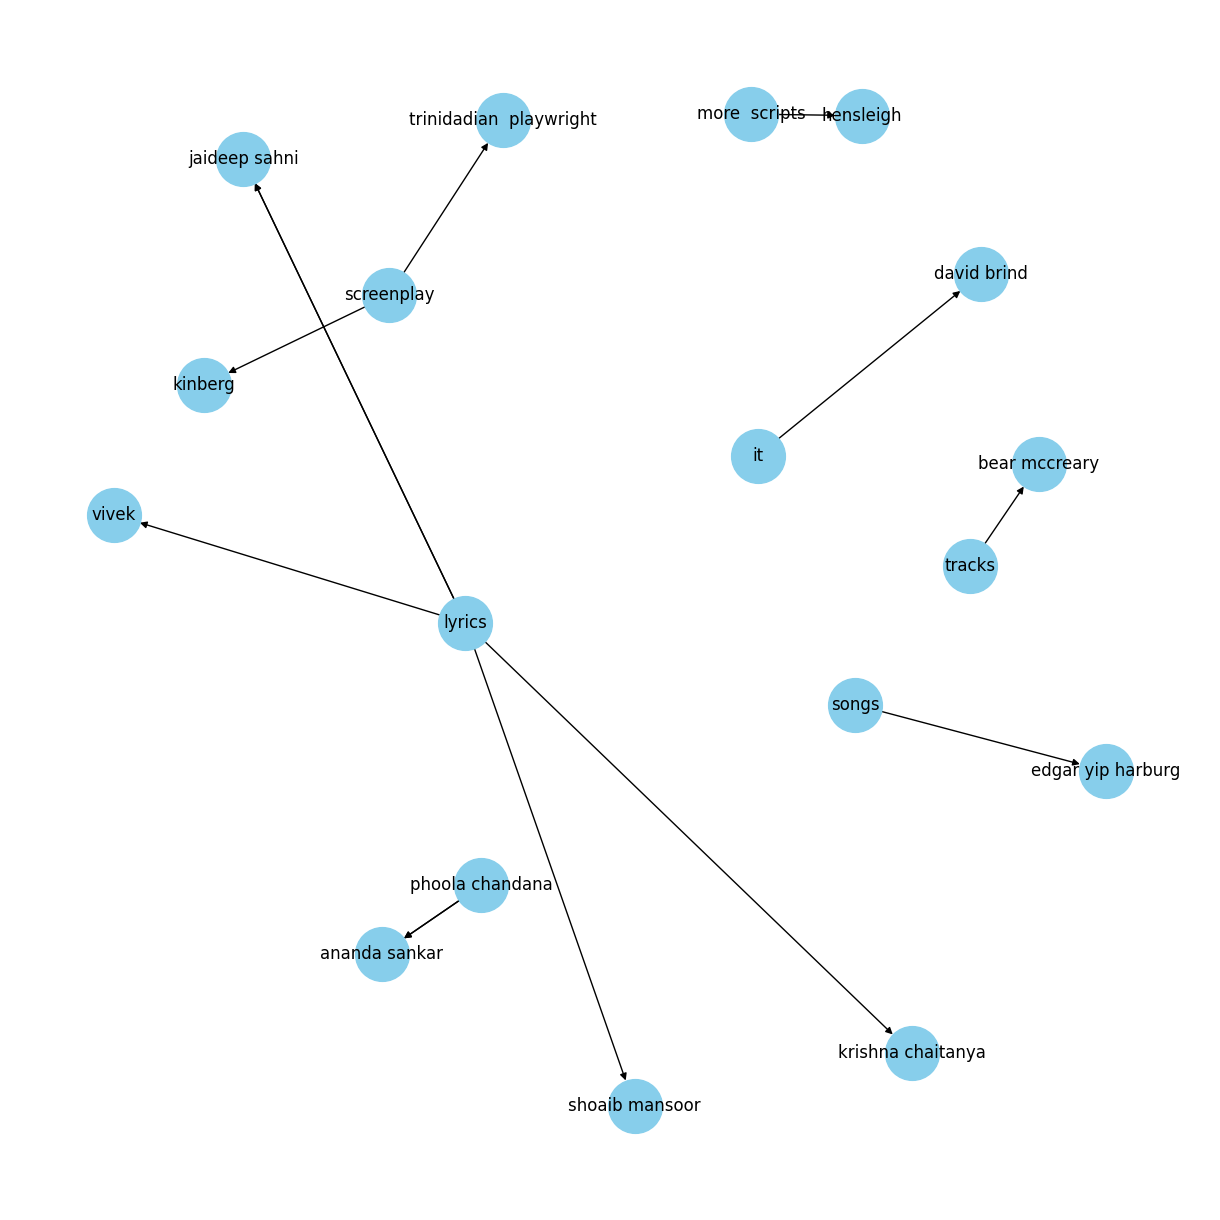

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

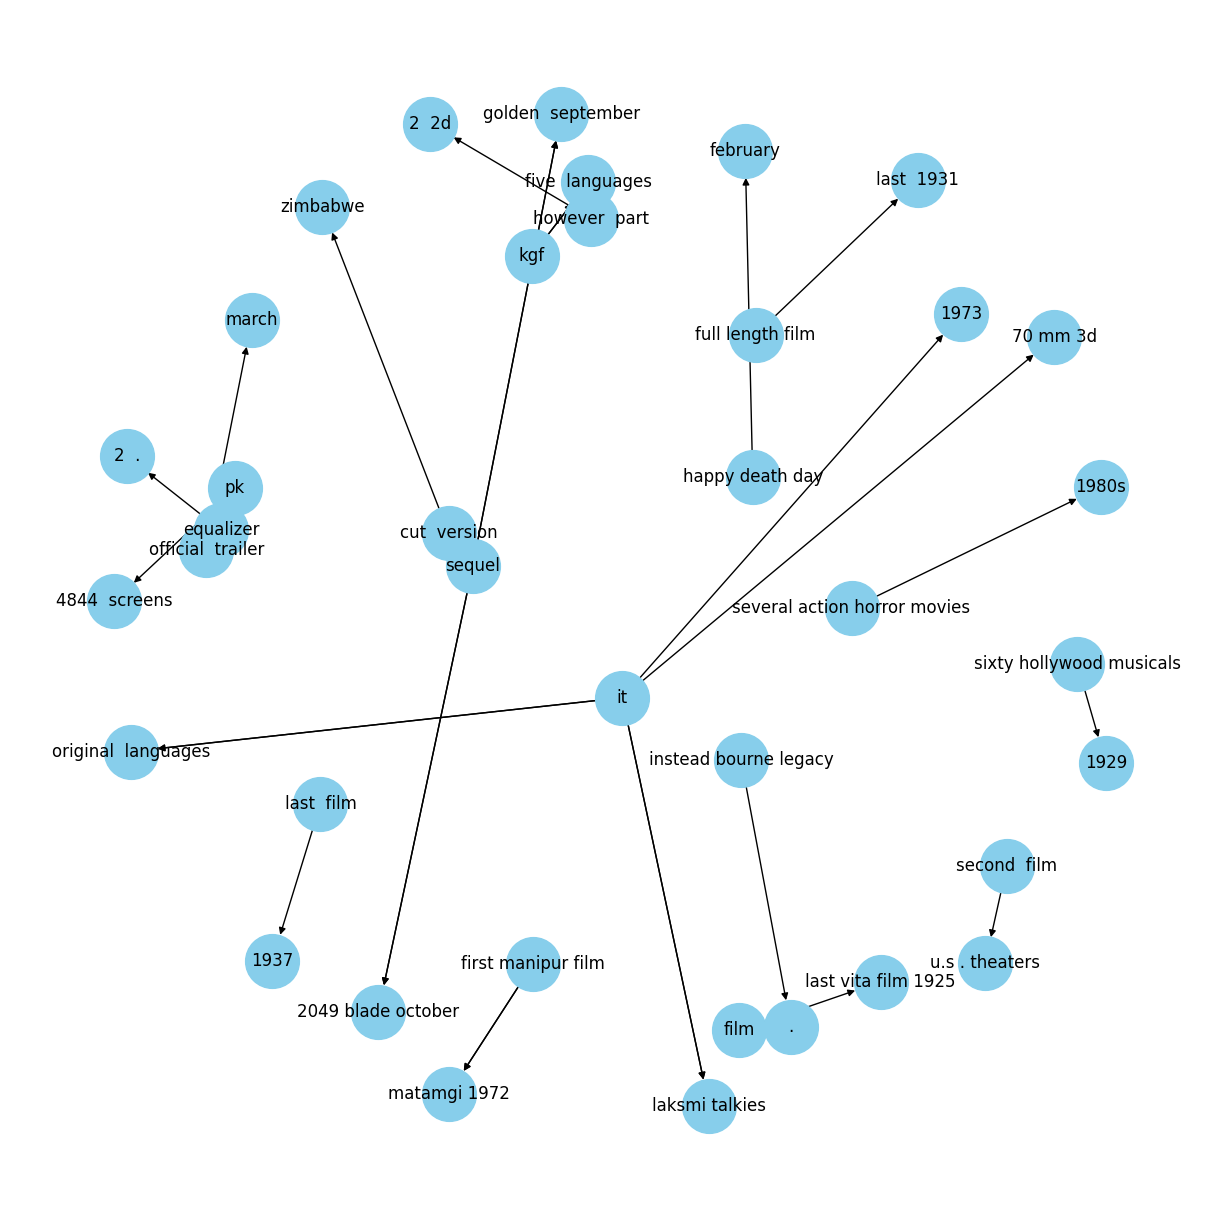

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()